# Task 4

Find the lowest eigenvalue of the following matrix:

$$
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & -1 & 0 & 0  \\
0 & 0 & 0 & 1 \\
\end{pmatrix}
$$

using VQE-like circuits, created by yourself from scratch.

# 1) Decomposing the desired matrix into pauli operators

Since we want to measure a VQE-like circuit, we need to decompose the matrix into their pauli components. We have that the pauli matrices are:

$$
\sigma_x = \begin{pmatrix}
    0 & 1 \\
    1 & 0
    \end{pmatrix} \hspace{1em} , \hspace{1em}  \sigma_y = \begin{pmatrix}
    0 & -i \\
    i & 0
    \end{pmatrix} \hspace{1em} , \hspace{1em}  \sigma_z = \begin{pmatrix}
    1 & 0 \\
    0 & -1
    \end{pmatrix}
$$

Thus to get the pauli component of a Matrix $2^N$ x $2^N$ matrix $A$, as stated on [stackoverflow](https://quantumcomputing.stackexchange.com/questions/8725/can-arbitrary-matrices-be-decomposed-using-the-pauli-basis), we have:

$$
A = \sum_{ij} \frac{1}{4} h_{ij} \hspace{0.5em} \sigma_i \otimes \sigma_j
$$

And the components $h_{ij}$ are:

$$
h_{ij} = \frac{1}{4} \mathrm{Tr} \bigg[ (\sigma_i \otimes \sigma_j) \cdot A \bigg]
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit

In [3]:
A = np.array([[1,0,0,0],[0,0,-1,0],[0,-1,0,0],[0,0,0,1]])
# Defining Pauli Matrices
pauli_x = np.array([[0,1],[1,0]]) ; pauli_y = np.array([[0,1j],[-1j,0]]) ; pauli_z = np.array([[1,0],[0,-1]])

name_basis = ['I', 'X', 'Y', 'Z']
basis = [np.eye(2), pauli_x, pauli_y, pauli_z]

In [4]:
from itertools import product

def get_components_from_matrix(A, basis, name_basis):
    
    components = []
    components_names = []
    components_dict = {}
    for (name_1, pauli_1),(name_2, pauli_2) in product(zip(name_basis, basis),zip(name_basis, basis)):        
        components_dict[name_1 + name_2] = np.trace(1/4.*np.kron(pauli_1,pauli_2) @ A)
    return components_dict

In [5]:
from itertools import product
components = get_components_from_matrix(A, basis, name_basis)

print("Decomposition:")
for name, comp in components.items():
    print(f"  {name} : {comp}")

# Now we can clean the dictionary removing keys that their 
# values are 0
cleaned_components = { key : val for key,val in components.items() if val != 0}
    
print("Clean decomposition:")
for name, comp in cleaned_components.items():
    print(f"  {name} : {comp}")

Decomposition:
  II : 0.5
  IX : 0.0
  IY : 0j
  IZ : 0.0
  XI : 0.0
  XX : -0.5
  XY : 0j
  XZ : 0.0
  YI : 0j
  YX : 0j
  YY : (-0.5+0j)
  YZ : 0j
  ZI : 0.0
  ZX : 0.0
  ZY : 0j
  ZZ : 0.5
Clean decomposition:
  II : 0.5
  XX : -0.5
  YY : (-0.5+0j)
  ZZ : 0.5


In [6]:
print("decomposition of A:")
decomp = 0.5*np.kron(np.eye(2), np.eye(2)) - 0.5*np.kron(pauli_x, pauli_x) - 0.5*np.kron(pauli_y, pauli_y)  + 0.5*np.kron(pauli_z, pauli_z)
print(f"""{decomp}""")

decomposition of A:
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


Now we know that the desired matrix, has the following pauli decomposition:

$$
A = 0.5 I \otimes I \ - \ 0.5 \sigma_x \otimes \sigma_x \ - \ 0.5 \sigma_y \otimes \sigma_y \ + \ 0.5 \sigma_z \otimes \sigma_z
$$

# 2) Creating VQE circuit

Now we want to construct the VQE and measure the pauli factors in order to get the lowest eigenvalue of $A$. This is done in three parts:
- 1) Construct the VQE Ansatz;
- 2) Construct XX, YY, and ZZ measurements;
- 3) Vary VQE Ansatz parameters and measure the eigenvalue.

## 2.1) Creating Ansatz

In order to create the Variational Ansatz, we need to create a parametrized circuit in Qiskit. This is done by using the `parameter` class in `qiskit.circuit`. 

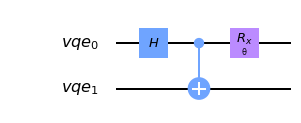

In [21]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit import execute, Aer
from qiskit.circuit import Parameter

theta = Parameter('θ')

qr = QuantumRegister(2, name='vqe')
qc = QuantumCircuit(qr)
qc.h(qr[0])
qc.cx(qr[0], qr[1])
qc.rx(theta, qr[0])
qc.draw('mpl')

## 2.2) Constructing XX, YY, and ZZ measurements

After creating our Ansatz, we need to measure the expected values of our pauli variables: XX, YY, and ZZ. The ZZ measurement is the easiest one, because the measurements are given on the computational basis, which is the same as saying that it is in the Z basis. For XX and YY measurements we need to make a change of basis in order to measure it, this will be explained in their respective sections.

### 2.2.1) Constructing ZZ measurement

Since the standard measurements are already in the ZZ basis, we only need to copy the circuit and use the `.measure_all()` method. Below there is a example of a circuit doing the ZZ measurement.

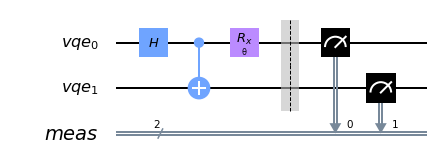

In [22]:
def measure_zz_circuit(circuit):
    """Measure the ZZ Component of the variational circuit."""
    zz_meas = circuit.copy()
    zz_meas.measure_all()
    return zz_meas

zz_meas = measure_zz_circuit(qc)
zz_meas.draw('mpl')

Now that we have created the ZZ circuit, we need a way to measure it. In this case we will do a sweep over the parametric variable $\theta$ and get the expected values for each value of the parameter.

In order to calculate the expected value, we need to see how a ZZ measurement will affect a arbitrary qubit:

$$
Z \otimes Z(a∣00\rangle+b∣01\rangle+c∣10\rangle+d∣11\rangle) =  a∣00\rangle−b∣01\rangle−c∣10\rangle+d∣11\rangle
$$

Thus in order to have the expectation value of Z, we have:
$$
\langle \psi | Z\otimes Z | \psi \rangle = \mathrm{Pr}(00) - \mathrm{Pr}(01) - \mathrm{Pr}(10) + \mathrm{Pr}(11)
$$

Where $\mathrm{Pr}(ij)$ is the probability of measuring the variable $ij$. In order to obtain the probabilities, we need to fill in a zero when the probability doesn't show up because qiskit will not put this probability in the dictionary.

In [23]:
def measure_zz(given_circuit: qiskit.QuantumCircuit, 
               theta_range: [list, np.array], 
               num_shots: int = 10000):
    """ Measure the ZZ expected value for a given_circuit.
    
    Args:
        given_circuit (qiskit.QuantumCircuit): The parametrized circuit that you 
        want to calculate the ZZ expected value.
        theta_range (Union[list, np.array]): Range of the parameter that you want
        to sweep.
        num_shots (int): Number of shots for each circuit run. (default=10000)
    
    Returns:
        zz (np.array): Expected values for each parameter.
    """
    zz_meas = measure_zz_circuit(given_circuit)

    simulator = qiskit.Aer.get_backend('qasm_simulator')
    
    job = execute(zz_meas,
              backend= simulator,
              shots= num_shots,
              parameter_binds=[{theta: theta_val} for theta_val in theta_range])
    
    counts = job.result().get_counts()

    zz = []
    for count in counts:        
        # Fill if the ij doesn't show up
        if '00' not in count:
            count['00'] = 0
        if '01' not in count:
            count['01'] = 0
        if '10' not in count:
            count['10'] = 0
        if '11' not in count:
            count['11'] = 0        
        
        # Get total counts in order to obtain the probability
        total_counts = count['00'] + count['11'] + count['01'] + count['10']
        # Get counts for expected value
        zz_meas = count['00'] + count['11'] - count['01'] - count['10']
        # Append the probability
        zz.append(zz_meas / total_counts)
    
    return np.array(zz)

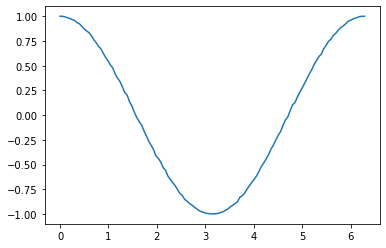

In [24]:
theta_range = np.linspace(0, 2 * np.pi, 128)
zz = measure_zz(qc, theta_range)
plt.plot(theta_range, zz);

### 2.2.2) Constructing YY measurement

In order to get the expectation value for the YY measurement, we need a change of basis because the measurement are only made on the Z basis. We use the following identity: $Y = (HS^\dagger)^\dagger Z H S^\dagger$, thus the YY expected value is:

$$
\langle \psi | Y  | \psi \rangle = (\langle \psi |(H S^\dagger)^\dagger) Z  (H S^\dagger| \psi \rangle) \equiv \langle \tilde \psi | Z | \tilde \psi \rangle
$$

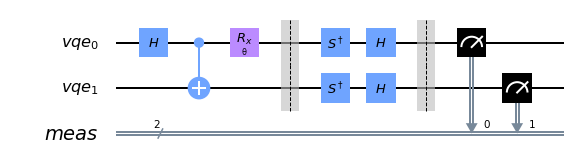

In [84]:
def measure_yy_circuit(circuit):
    """Measure the YY Component of the variational circuit."""
    yy_meas = circuit.copy()
    yy_meas.barrier(range(2))
    yy_meas.sdg(range(2))    
    yy_meas.h(range(2))    
    yy_meas.measure_all()
    return yy_meas

yy_meas = measure_yy_circuit(qc)
yy_meas.draw('mpl')

In [82]:
def measure_yy(given_circuit: qiskit.QuantumCircuit, 
               theta_range: [list, np.array], 
               num_shots: int = 10000):
    """ Measure the YY expected value for a given_circuit.
    
    Args:
        given_circuit (qiskit.QuantumCircuit): The parametrized circuit that you 
        want to calculate the YY expected value.
        theta_range (Union[list, np.array]): Range of the parameter that you want
        to sweep.
        num_shots (int): Number of shots for each circuit run. (default=10000)
    
    Returns:
        yy (np.array): Expected values for each parameter.
    """
    
    yy_meas = measure_yy_circuit(given_circuit)
    
    simulator = Aer.get_backend('qasm_simulator')
    
    job = execute(yy_meas,
              backend= simulator,
              shots=num_shots,
              parameter_binds=[{theta: theta_val} for theta_val in theta_range])
    
    counts = job.result().get_counts()

    yy = []
    for count in counts:        
        if '00' not in count:
            count['00'] = 0
        if '01' not in count:
            count['01'] = 0
        if '10' not in count:
            count['10'] = 0
        if '11' not in count:
            count['11'] = 0        
        
        total_counts =  count['00'] + count['11'] + count['01'] + count['10']
        
        yy_meas =  count['00'] + count['11'] - count['01'] - count['10']
        yy.append(yy_meas / total_counts)
    
    return np.array(yy)

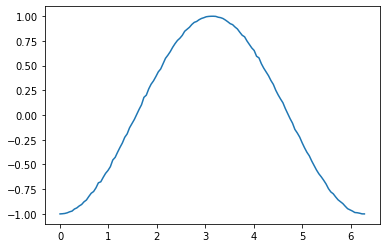

In [83]:
theta_range = np.linspace(0, 2 * np.pi, 128)
yy = measure_yy(qc, theta_range)
plt.plot(theta_range, yy);

### 2.2.3) Constructing XX measurement

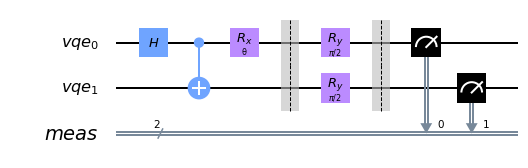

In [73]:
def measure_xx_circuit(circuit):
    """Measure the XX Component of the variational circuit."""
    xx_meas = circuit.copy()  
    xx_meas.barrier(range(2))
    xx_meas.ry(np.pi/2., range(2))
    #     xx_meas.h(range(2)) 
    xx_meas.measure_all()    
    return xx_meas

xx_meas = measure_xx_circuit(qc)
xx_meas.draw('mpl')

In [74]:
def measure_xx(given_circuit: qiskit.QuantumCircuit, 
               theta_range: [list, np.array], 
               num_shots: int = 10000):
    """ Measure the XX expected value for a given_circuit.
    
    Args:
        given_circuit (qiskit.QuantumCircuit): The parametrized circuit that you 
        want to calculate the XX expected value.
        theta_range (Union[list, np.array]): Range of the parameter that you want
        to sweep.
        num_shots (int): Number of shots for each circuit run. (default=10000)
    
    Returns:
        xx (np.array): Expected values for each parameter.
    """
    xx_meas = measure_xx_circuit(given_circuit)    

    simulator = Aer.get_backend('qasm_simulator')
    
    job = execute(xx_meas,
              backend= simulator,
              shots=num_shots,
              parameter_binds=[{theta: theta_val} for theta_val in theta_range])
    
    counts = job.result().get_counts()

    xx = []
    
    for count in counts:        
        if '00' not in count:
            count['00'] = 0
        if '01' not in count:
            count['01'] = 0
        if '10' not in count:
            count['10'] = 0
        if '11' not in count:
            count['11'] = 0         
            
        total_counts = count['00'] + count['11'] + count['01'] + count['10']
        
        xx_meas = count['00'] + count['11'] - count['01'] - count['10']
        xx.append(xx_meas / total_counts)
    
    return np.array(xx)

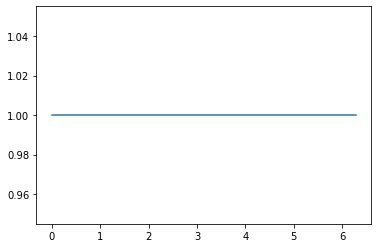

In [75]:
theta_range = np.linspace(0, 2 * np.pi, 128)
xx = measure_xx(qc, theta_range)
plt.plot(theta_range, xx);

## 2.3) Getting the eigenvalue

In [76]:
def get_energy(circuit, theta_range, num_shots = 10000):
    
    xx = measure_xx(circuit, theta_range, num_shots = num_shots)
    yy = measure_yy(circuit, theta_range, num_shots = num_shots)
    zz = measure_zz(circuit, theta_range, num_shots = num_shots)    
    
    energy = 0.5*1 \
             - 0.5*xx \
             - 0.5*yy \
             + 0.5*zz
    
    return energy

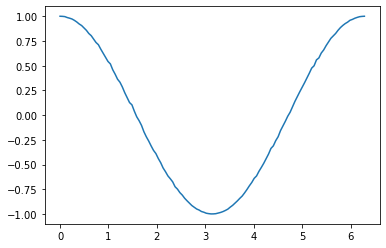

In [77]:
theta_range = np.linspace(0, 2 * np.pi, 128)
energy = get_energy(qc, theta_range)
plt.plot(theta_range, energy)
plt.show()

In [58]:
np.round(np.min(energy),4)

-0.5004

In [188]:
thetas[np.argmin(energy)]

3.017907903448463

--------------------------------------------

In [1]:
from qiskit.tools.jupyter import *
%qiskit_version_table